# Ground-roll attenuation model with attention

This notebook reproduces model and model training and evaluation pipelines according to the paper [Attention-based neural network for improved ground-roll
attenuation in land seismic surveys]().

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)

## Dataset

Dataset consists of a 50 raw field shot gathers before and after ground-roll attenuation processing according to industrial standatrd. Seismic traces have 6s lengths and 2ms sample interval. Dataset is split into train and validation parts. Train parts contains 19 shot gathers.

Required imports:

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sh

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, V, B, L, I, W
from seismicpro.batchflow.models.tf.layers import conv_block

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import UnetAtt, attention_loss, FieldMetrics

%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


Index and merge datasets of input and target traces:

In [2]:
path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset', 'SourceX', 'SourceY'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,offset,SourceX,TraceNumber,SourceY,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,,,raw,raw,lift,lift
FieldRecord,,,,,,,,
111906,35,499287,1656,6639813,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,36,499287,1657,6639813,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,78,499287,1655,6639813,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,79,499287,1658,6639813,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,127,499287,1654,6639813,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 19 field records for model training:

In [3]:
train_index = index.create_subset(index.indices[:19])
test_index = index.create_subset(index.indices[19:])
train_set = SeismicDataset(TraceIndex(train_index))

Show relative positions of train and test shot gathers:

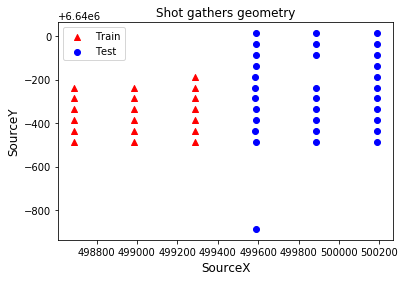

In [4]:
train_shots = train_index.get_df()[['SourceX', 'SourceY']].drop_duplicates()
test_shots = test_index.get_df()[['SourceX', 'SourceY']].drop_duplicates()
plt.scatter(*train_shots.values.T, marker="^", c='r', label='Train')
plt.scatter(*test_shots.values.T, c='b', label='Test')
plt.title('Shot gathers geometry')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.legend()
plt.show()

Sample of raw and target shot gather form train dataset. Here and in each seismic plot below
X-axis represents trace number in offset sorting, Y-axis counts time samples. 

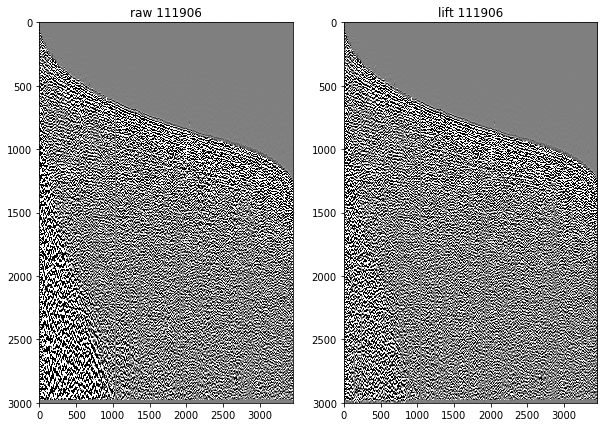

In [5]:
(SeismicDataset(train_index).next_batch(1)
 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
 .seismic_plot(('raw', 'lift'), index.indices[0], figsize=(10, 7),
               vmax=0.1, vmin=-0.1, cmap='gray'))

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask. In the next cell we set model and loss function configurations:

In [6]:
model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
#                    offset={'shape': (1, )},
                   lift={'name': 'targets', 'shape': (3000, 1)}),

    'loss': (attention_loss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.001}),
#     'decay': {'name': 'cyclic', 'learning_rate':0.0001, 'max_lr': 0.003, 'step_size': 20},
#     'decay': {'name': 'invtime', 'learning_rate':0.001, 'decay_steps': 100, 'decay_rate': 0.05},
    'common/data_format': 'channels_last',
    'body': {
        'main': {
            'encoder/num_stages': 5,
            'encoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256],
                                   kernel_size=7,
                                   activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd',
                                       pool_size=2,
                                       pool_strides=2,
                                       dropout_rate=0.05),

            'decoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256][::-1],
                                   kernel_size=7,
                                   activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad',
                                     kernel_size=7,
                                     strides=2,
                                     dropout_rate=0.05,
                                     activation=tf.nn.elu,),
          },
        'attn': {
              'encoder/num_stages': 3,
              'encoder/blocks': dict(layout='ca ca',
                                     filters=[8, 16, 32],
                                     kernel_size=3,
                                     activation=tf.nn.elu),
              'encoder/downsample': dict(layout='pd',
                                         pool_size=2,
                                         pool_strides=2,
                                         dropout_rate=0.05),

              'decoder/blocks': dict(layout='ca ca',
                                     filters=[8, 16, 32][::-1],
                                     kernel_size=3,
                                     activation=tf.nn.elu),
              'decoder/upsample': dict(layout='ta d',
                                       kernel_size=3,
                                       strides=2,
                                       dropout_rate=0.05,
                                       activation=tf.nn.elu),
        },
    },
    'head': {'layout': 'fafafa', 'units':[16, 16, 1], 'activation':tf.nn.elu},
    'train_steps': {
#         'sss': {},
        'step_main': {'scope': 'main_branch'},
        'step_attention': {'scope': ['attention_branch', 'attention_dense']},
    }
}

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 5.

Training pipeline configuration:

In [7]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw),
            'lift': exp_stack(batch.lift)}

train_pipeline = (Pipeline()
                  .init_model('static', UnetAtt, name='unet', config=model_config)
                  .init_variable('loss', default=list())
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .train_model('unet', make_data=make_data, fetches='loss_step_main',
                               save_to=V('loss', 'a'))
                 )

Bind dataset and pipeline for model training:

In [8]:
train_pipeline = train_pipeline << train_set

Run model training for 5 epochs with batch size of 64:

In [9]:
batch_size = 64

train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=3, drop_last=True,
                                    shuffle=True, bar=True,
                                    bar_desc=W(V('loss')[-1].format('Current loss is: {:7.7}')))

Current loss is: 0.009567477: 100%|██████████| 3078/3078 [15:34<00:00,  3.34it/s]


Plot of loss terms decay:

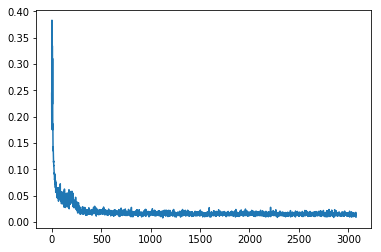

In [10]:
loss = np.array(train_pipeline.get_variable('loss'))
plt.plot(loss)
plt.show()

In [11]:
# loss = np.array(train_pipeline.get_variable('train_loss'))

# df = pd.DataFrame(loss[:, [1, 2, 0]])
# #Select and weight individual loss terms from total loss
# df[[0, 1]] = df[[0, 1]] * 0.05
# df[2] -= df[0] + df[1]

# avl = df.rolling(100).mean().values
# plt.stackplot(np.arange(len(avl)), avl.T,
#               labels=['Area loss','Localization loss','Main loss'])
# plt.legend(fontsize=10)
# plt.xlabel('Iterations', fontsize=12)
# plt.ylabel('Loss', fontsize=12)
# plt.title('UnetAttention loss')
# plt.show()

Save the model:

In [12]:
model_path = './unet_att_model'
train_pipeline.save_model_now('unet', model_path)

## Inference

For trace-by-trace inference we convert original index to ```TraceIndex```:

In [13]:
inference_index = TraceIndex(index)

Inference pipeline configuration. Temporary folder ```tmp_dump_path``` will contain processed batches in separate files.

In [14]:
tmp_dump_path = '/data/NA/tmp'

def make_data_inference(batch, **kwagrs):
    return {"feed_dict": {'trace_raw': exp_stack(batch.raw)}}

inference_ppl = (Pipeline()
                 .import_model('unet', train_pipeline)
#                  .load_model("static", UnetAtt, 'unet', path=model_path)    # Use this action instead of `import_model` if you didn't run training
                 .init_variable('res')
                 .load(components='raw', fmt='segy', tslice=np.arange(3000))
                 .predict_model('unet', make_data=make_data_inference,
                                fetches=['out_lift'], save_to=B('raw'))
                 .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()),
                       src='raw', fmt='segy', split=False)
                 )

Bind a dataset and inference pipeline:

In [15]:
inference_set = SeismicDataset(inference_index)

inference_ppl = inference_ppl << inference_set

Run inference pipeline with appropriate ```batch_size```:

In [16]:
batch_size = 2000
inference_ppl.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

100%|██████████| 88/88 [03:53<00:00,  3.79s/it]


Final and rather optional step is to merge dumped files into a single file:

In [17]:
output_path = '/data/NA/processed/merged.sgy'
merge_segy_files(output_path=output_path, extra_headers='all',
                 path=os.path.join(tmp_dump_path, '*.sgy'))
sh.rm(sh.glob(os.path.join(tmp_dump_path, '*')))

100%|██████████| 88/88 [00:42<00:00,  2.08it/s]


For a quick estimation let's look at the first field record from the final file:

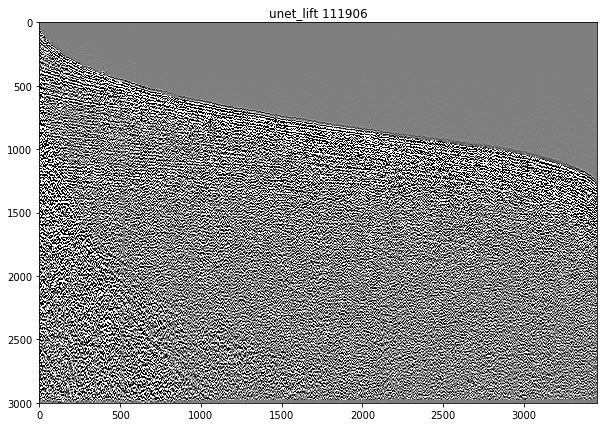

In [18]:
output_index = FieldIndex(name='unet_lift', extra_headers=['offset'], path=output_path)

(SeismicDataset(output_index).next_batch(1)
 .load(components='unet_lift', fmt='segy', tslice=np.arange(3000))
 .sort_traces(src='unet_lift', dst='unet_lift', sort_by='offset')
 .seismic_plot('unet_lift', index.indices[0], figsize=(10, 7), vmax=0.1, vmin=-0.1, cmap='gray'))

## Running time

For GTX 1080 we obtain:
* training time per one batch of size 64 traces is 0.3 sec
* full model training time with batch size 64 is 26 min
* inference time per one batch of size 2000 traces is 4.3 sec

## Model evaluation

For model evaluation we first consider a sample seismogram form test set and compare it with
input and trarget seismograms.

Test pipeline:

In [19]:
fetches=['out_lift', 'attention_sigmoid', 'sigmoid_center']

test_pipeline = (Pipeline()
                 .import_model('unet', train_pipeline)
                 .init_variable('res', list())
                 .init_variable('raw', list())
                 .init_variable('lift', list())
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .predict_model('unet', make_data=make_data, fetches=fetches, save_to=V('res', 'a')))

Select a sample seismogram for testing:

In [20]:
i = 10
test_set = SeismicDataset(TraceIndex(test_index.create_subset(test_index.indices[i: i+1])))

Run test pipeline:

In [21]:
test_pipeline = test_pipeline << test_set
test_pipeline = test_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

100%|██████████| 4/4 [00:08<00:00,  2.31s/it]


Arrange results:

In [22]:
raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))
sigm_center = np.squeeze(np.vstack([x[2] for x in test_pipeline.get_variable('res')]))

### Visual estimation

Show raw seismogram, model attention mask, model output and difference between model output and raw input:

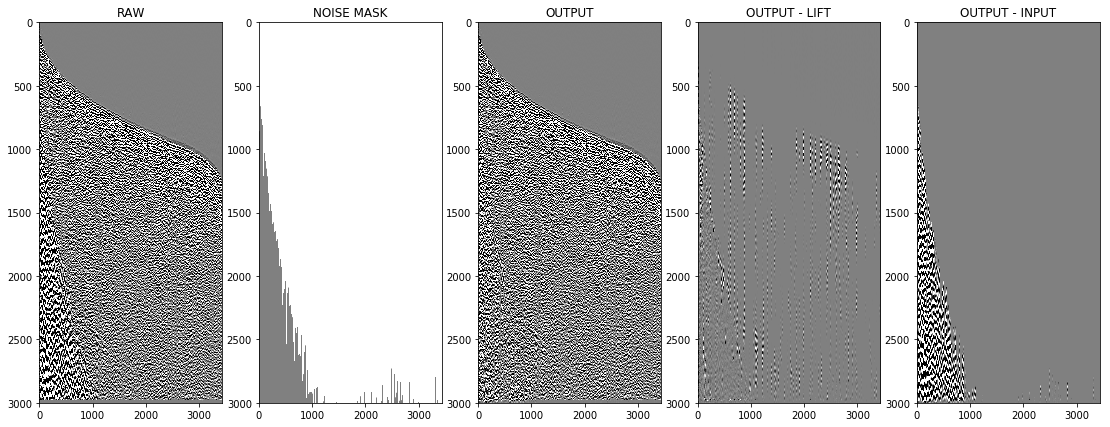

In [23]:
cv = 0.1
seismic_plot([raw, att, out, out - lift, out - raw],
             figsize=(19, 7), names=['RAW', 'NOISE MASK', 'OUTPUT', 'OUTPUT - LIFT', 'OUTPUT - INPUT'],
             cmap='gray', vmin=-cv, vmax=cv)

Show model output, traget seismogram difference between them:

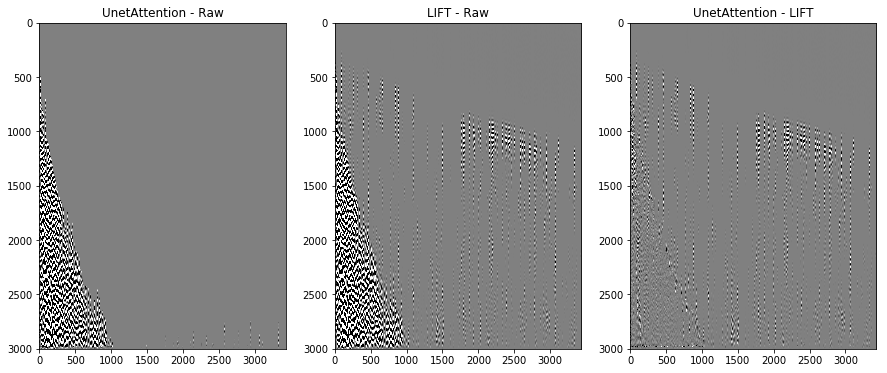

In [24]:
seismic_plot([out - raw, lift - raw, out - lift],
             figsize=(15, 6), names=['UnetAttention - Raw', 'LIFT - Raw', 'UnetAttention - LIFT'],
             cmap='gray', vmin=-cv, vmax=cv)

Note a difference outside the ground-roll area for LIFT seismogram.

### MAE metrics

Estimate MAE between model output and target seismogram:

In [25]:
mtr = FieldMetrics(lift, out)
print('MAE:', mtr.mae())

MAE: 0.0051928475


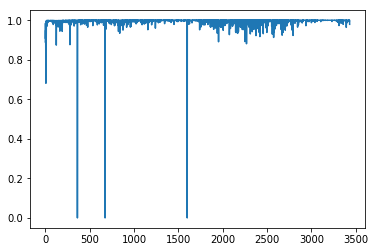

Averaged correlation: 0.9953219


In [26]:
corr = mtr.corr_coef(reduce=None)
plt.plot(corr)
plt.show()

print('Averaged correlation:', mtr.corr_coef())

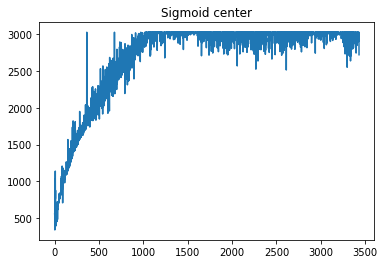

In [27]:
plt.plot(sigm_center)
plt.title('Sigmoid center')
plt.show()

### Ground-roll cone approximation

Show ground-roll cone approximation given by thresholded difference of input and target seismograms and given by attention mask:

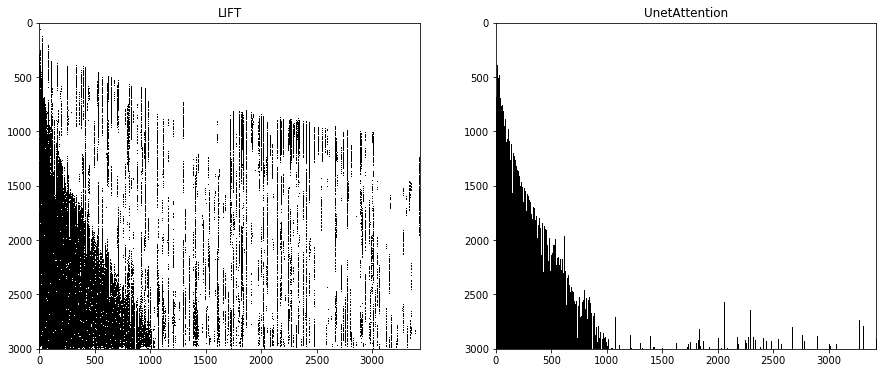

In [28]:
seismic_plot([abs(lift - raw) < .007, att > 0.5],
             names=['LIFT', 'UnetAttention'],
             figsize=(15, 6), vmin=0, vmax=1, cmap='gray'
            )

In [29]:
thrs = np.arange(0, .5, 0.01)
vals = np.array([FieldMetrics(abs(lift - raw) > p, att < 0.5).iou() for p in thrs])

Best threshold is 0.05 with IOU =  0.7958201292064105


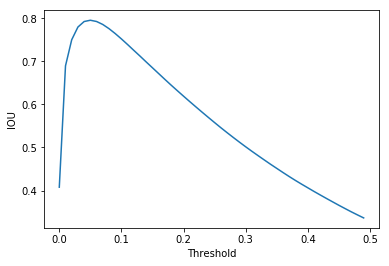

In [30]:
plt.plot(thrs, vals)
plt.xlabel('Threshold'), plt.ylabel('IOU')
print('Best threshold is', thrs[np.argmax(vals)], 'with IOU = ', vals.max())
plt.show()

Compute IoU for binary masks obtained:

In [31]:
FieldMetrics(abs(lift - raw) > 0.06, att < 0.5).iou()

0.7929143212653246

### Power spectrum comparison

Power spectrum comparison in the gourd roll area:

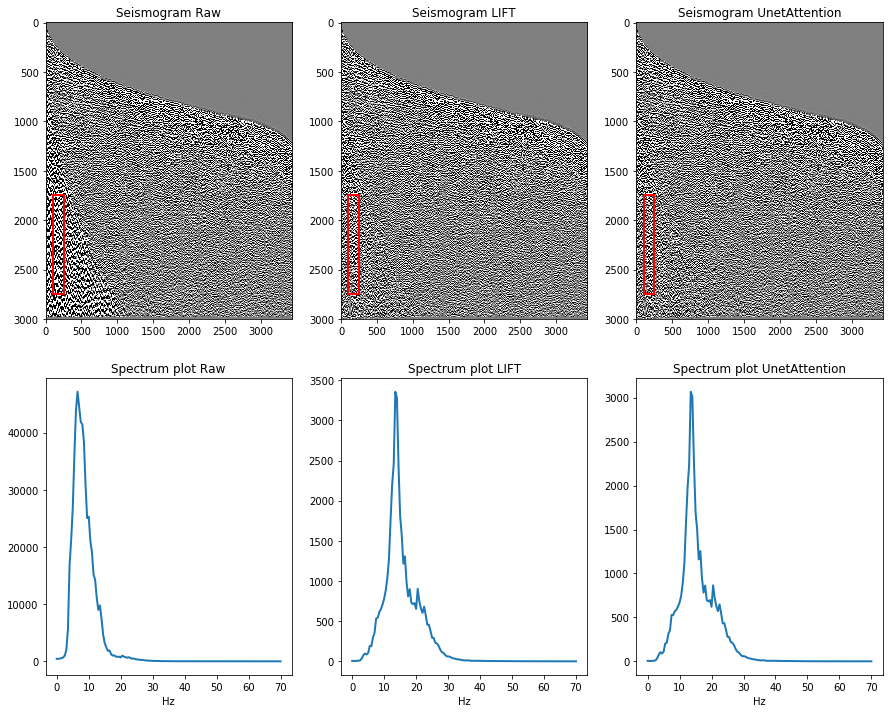

In [32]:
spectrum_plot([raw, lift, out],
              frame=(slice(100, 250), slice(1750, 2750)), rate=0.002, max_freq=70,
              figsize=(15, 12), vmin=-cv, vmax=cv, cmap='gray',
              names=['Raw', 'LIFT', 'UnetAttention']
             )

We observe a very similar distribution of power spectrum in the gound-roll area for LIFT and UnetAttention model.

### Metrics evaluation on the whole dataset

We will evaluate MAE and signal-to-noise ration for each shot gather. The result will be plotted in a scatter plot, where color indicates metrics value and point coordinates correspond to shot point coordinates.

Add predicted seismograms to index:

In [33]:
path_unet = '/data/NA/processed/merged.sgy'
index = index.merge(FieldIndex(name='unet', extra_headers=['SourceX', 'SourceY'], path=path_unet))

Configure pipeline for metrics evaluation:

In [34]:
def get_pos(batch, *args):
    sx = batch.trace_headers('SourceX', flatten=True)[0]
    sy = batch.trace_headers('SourceY', flatten=True)[0]
    ffid = batch.trace_headers('FieldRecord', flatten=True)[0]
    return sx, sy, ffid

def eval_mt(batch, *args):
    mt = FieldMetrics(batch.lift[0], batch.unet[0], batch.raw[0])
    snr_lift = mt.signaltonoise2(src_clean='targets', src_noised='raw')
    snr_unet = mt.signaltonoise2(src_clean='predictions', src_noised='raw')
    return mt.mae(), snr_lift, snr_unet
    

metr_pipeline = (Pipeline()
                 .init_variable('mt', [])
                 .init_variable('pos', [])
                 .load(components=('unet', 'lift', 'raw'), fmt='segy', tslice=np.arange(3000))
                 .call(get_pos, save_to=V('pos', mode='a'))
                 .call(eval_mt, save_to=V('mt', mode='a')))

Bind pipeline with dataset and run evaluations:

In [35]:
metr_pipeline = metr_pipeline << SeismicDataset(index)
metr_pipeline = metr_pipeline.run(batch_size=1, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

100%|██████████| 51/51 [01:35<00:00,  1.87s/it]


Arrange results:

In [36]:
pos = np.vstack(metr_pipeline.get_variable('pos'))
mt = np.vstack(metr_pipeline.get_variable('mt'))
mae, snr_lift, snr_unet = mt[:, 0], mt[:, 1], mt[:, 2]

MAE distribution over shot gathers:

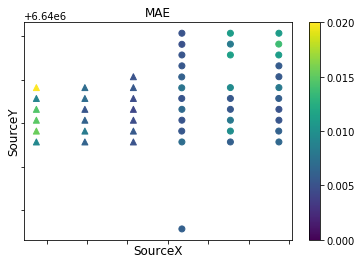

Mean train value = 0.008
Mean test value = 0.007


In [37]:
vmin = 0
vmax = 0.02
plt.scatter(*pos[:19, :2].T, c=mae[:19], marker="^", vmin=vmin, vmax=vmax)
plt.scatter(*pos[19:, :2].T, c=mae[19:], vmin=vmin, vmax=vmax)
plt.colorbar(ticks=np.linspace(0, vmax, 5))
plt.title('MAE')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.tick_params(axis='both', which='both',
                labelbottom=False, labeltop=False, labelleft=False)
plt.show()
print('Mean train value = {:.3f}'.format(np.mean(mae[:19])))
print('Mean test value = {:.3f}'.format(np.mean(mae[19:])))

SNR distribution over shot gathers for LIFT:

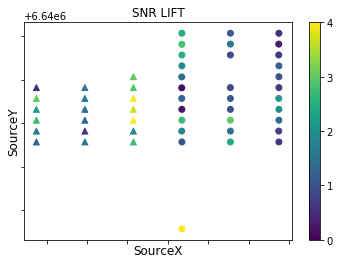

Mean train value = 2.239
Mean test value = 1.499


In [38]:
vmin = 0
vmax = 4
plt.scatter(*pos[:19, :2].T, c=snr_lift[:19], marker="^", vmin=vmin, vmax=vmax)
plt.scatter(*pos[19:, :2].T, c=snr_lift[19:], vmin=vmin, vmax=vmax)
plt.colorbar(ticks=np.linspace(0, vmax, 5))
plt.title('SNR LIFT')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.tick_params(axis='both', which='both',
                labelbottom=False, labeltop=False, labelleft=False)
plt.show()
print('Mean train value = {:.3f}'.format(np.mean(snr_lift[:19])))
print('Mean test value = {:.3f}'.format(np.mean(snr_lift[19:])))

SNR distribution over shot gathers for UnetAttention:

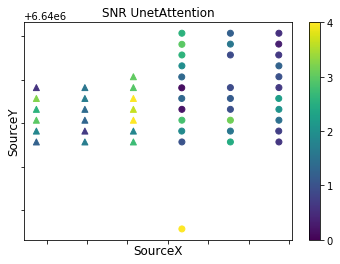

Mean train value = 2.289
Mean test value = 1.533


In [39]:
vmin = 0
vmax = 4
plt.scatter(*pos[:19, :2].T, c=snr_unet[:19], marker="^", vmin=vmin, vmax=vmax)
plt.scatter(*pos[19:, :2].T, c=snr_unet[19:], vmin=vmin, vmax=vmax)
plt.colorbar(ticks=np.linspace(0, vmax, 5))
plt.title('SNR UnetAttention')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.tick_params(axis='both', which='both',
                labelbottom=False, labeltop=False, labelleft=False)
plt.show()
print('Mean train value = {:.3f}'.format(np.mean(snr_unet[:19])))
print('Mean test value = {:.3f}'.format(np.mean(snr_unet[19:])))

Done! We do not provide here pipelines for model validation around well since it is related to external software.

You are welcome to explore [https://github.com/gazprom-neft](https://github.com/gazprom-neft) repository for more models and seismic processing tools.